In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import string
import pickle
import emoji
import scipy.stats as ss
import sklearn
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.validation import check_is_fitted

%matplotlib inline

In [2]:
df1 = pd.read_csv('emotion-labels-test.csv')
df2 = pd.read_csv('emotion-labels-train.csv')
df = pd.DataFrame(pd.concat([df1,df2]))

In [3]:
df

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy
...,...,...
3608,@VivienLloyd Thank you so much! Just home - st...,sadness
3609,Just put the winter duvet on ☃️❄️🌬☔️,sadness
3610,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness
3611,@BluesfestByron second artist announcement loo...,sadness


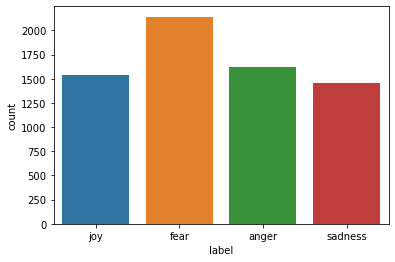

In [4]:
sns.countplot(data=df, x='label')

In [5]:
#Let's see if the length of the message affects the label 
df['text_len'] = df['text'].apply(lambda x: len(x))
df_bylabel = df.groupby('label').sum()

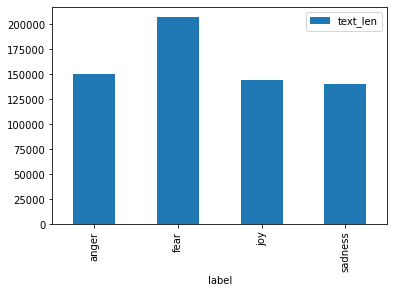

In [6]:
df_bylabel.plot.bar()
#We see the same distribution per category

In [8]:
df = df.applymap(str)

In [9]:
lemmatizer = WordNetLemmatizer()

#Convert emojis to words 
with open('Emoji_Dict.p', 'rb') as fp:
        Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(mess):
    for emot in Emoji_Dict:
        mess = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), mess)
    return mess

def text_process(mess):
    #Convert emojis to words
    mess = convert_emojis_to_word(mess)

    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    stop = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    #Lemmatize
    lemma = []
    for lem in stop: 
        lemma.append(lemmatizer.lemmatize(lem, pos ="v"))

    return lemma

In [10]:
#Now let's tokenize the data
#df['text'] = df['text'].apply(text_process)

In [11]:
df.head()

,text,label,text_len
0,You must be knowing #blithe means (adj.) Happ...,joy,58
1,Old saying 'A #smile shared is one gained for ...,joy,82
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy,60
3,@Elaminova sparkling water makes your life spa...,joy,50
4,I'm tired of everybody telling me to chill out...,joy,125


In [12]:
#Time to create the Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['text'])

In [14]:
text_bow = bow_transformer.transform(df['text'])

In [15]:
print('Shape of Sparse Matrix: ', text_bow.shape)
print('Amount of Non-Zero occurences: ', text_bow.nnz)

Shape of Sparse Matrix:  (6755, 16522)
Amount of Non-Zero occurences:  63481


In [16]:
sparsity = (100.0 * text_bow.nnz / (text_bow.shape[0] * text_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(text_bow)
text_tfidf = tfidf_transformer.transform(text_bow)
print(text_tfidf.shape)

(6755, 16522)


In [18]:
from sklearn.naive_bayes import MultinomialNB
sentiment_analysis_model = MultinomialNB().fit(text_tfidf, df['label'])

In [19]:
all_predictions = sentiment_analysis_model.predict(text_tfidf)
print(all_predictions)

['joy' 'joy' 'joy' ... 'sadness' 'sadness' 'sadness']


In [20]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(df['text'], df['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

5404 1351 6755


In [21]:
from sklearn.pipeline import Pipeline

In [24]:
from sklearn.metrics import classification_report

Random Forest

In [25]:
#Try RFC!
from sklearn import preprocessing
Encode = preprocessing.LabelEncoder()
from sklearn.ensemble import RandomForestClassifier

In [26]:
vect = CountVectorizer()
msg_train_vect = vect.fit_transform(msg_train)
msg_test_vect = vect.fit_transform(msg_test)

In [33]:
#Test the models
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest Classifier': RandomForestClassifier(random_state=143, n_jobs=8),
    'Support Vector Machine': LinearSVC(max_iter=10000, random_state=143),
    'K-Nearest-Neighbor': KNeighborsClassifier(n_neighbors=4)
}

for clas in classifiers: 
    
    #Create pipeline
    pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', classifiers[clas])  # train on TF-IDF vectors
    ])

    #Fitting pipeline
    pipeline.fit(msg_train,label_train)

    #Cross-Validation
    scores = cross_val_score(classifiers[clas], msg_train_vect, label_train)

    #Model resulting metrics
    preds = pipeline.predict(msg_test)
    print('Model used: ', clas)
    print('Cross Validation Scores: ',scores)
    print('Classification Report: ')
    print(classification_report(preds,label_test))
    print('Confusion Matrix: ')
    print(confusion_matrix(preds,label_test))
    print("Accuracy Score: ", accuracy_score(preds, label_test))
    print('\n\n')
    

Model used:  Naive Bayes
Cross Validation Scores:  [0.80481036 0.81128585 0.80018501 0.81128585 0.79166667]
Classification Report: 
              precision    recall  f1-score   support

       anger       0.78      0.87      0.82       290
        fear       0.95      0.67      0.78       626
         joy       0.76      0.95      0.85       246
     sadness       0.56      0.84      0.67       189

    accuracy                           0.79      1351
   macro avg       0.76      0.83      0.78      1351
weighted avg       0.83      0.79      0.79      1351

Confusion Matrix: 
[[252   9   7  22]
 [ 49 417  64  96]
 [  6   0 234   6]
 [ 17  11   2 159]]
Accuracy Score:  0.7860843819393042



Model used:  Random Forest Classifier
Cross Validation Scores:  [0.84181314 0.84088807 0.84828862 0.86123959 0.84259259]
Classification Report: 
              precision    recall  f1-score   support

       anger       0.79      0.90      0.85       284
        fear       0.94      0.77      0.85 

Random Forest Classifier - Grid Search

In [34]:
#Let's do a grid search for the rfc (model that might be used)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pipeline_gs = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer())  # integer counts to weighted TF-IDF scores
    ])

pip = make_pipeline(pipeline_gs, RandomForestClassifier(criterion='gini', random_state=1))
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2,5,10,100,200],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6],
    'randomforestclassifier__n_estimators':[1,5,10,20,100]
}]

gs = GridSearchCV(estimator = pip,
                     param_grid = param_grid_rfc,
                     scoring = 'accuracy',
                     cv = 10,
                     refit = True,
                     n_jobs = 1,
                     verbose = 10)
        
gs = gs.fit(msg_train, label_train)
# Print the training score of the best model
print(gs.best_score_)

# Print the model parameters of the best model
print(gs.best_params_)

# Print the test score of the best model
clfRFC = gs.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(msg_test, label_test))

Fitting 10 folds for each of 125 candidates, totalling 1250 fits
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.316, total=15.0min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.0min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.316, total=14.5min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 29.6min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.316, total=14.9min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 44.4min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.316, total=15.3min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 59.8min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.317, total=15.7min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 75.5min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.315, total=16.5min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 91.9min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.315, total=19.2min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 111.1min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.315, total=13.7min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 124.8min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.315, total=15.0min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 139.8min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=1, score=0.315, total=16.6min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=5 
[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=5, score=0.318, total=16.5min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=5 
[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=5, score=0.318, total=15.9min
[CV] randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=5 
[CV]  randomforestclassifier__max_depth=2, randomforestclassifier__max_features=2, randomforestclassifier__n_estimators=5, score=0.314, total=14.6min
[CV] randomforestclassifier__max_d

K-Nearest-Neighbor - Grid Search

In [ ]:
knn_gs = KNeighborsClassifier()
k_range = list(range(1, 100))
param_grid_knn = dict(n_neighbors=k_range)
  
# defining parameter range
pip = make_pipeline(pipeline_gs, KNeighborsClassifier())
grid = GridSearchCV(estimator = pip,
                     param_grid = param_grid_knn,
                     cv=10,
                     scoring='accuracy',
                     return_train_score=False,
                     verbose=10)
  
# fitting the model for grid search
grid_search = grid.fit(msg_train, label_train)
print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

Support Vector Machine - Grid Search

In [ ]:
#TODO
svc_gs = LinearSVC()

pip = make_pipeline(pipeline_gs, svc_gs)

# defining parameter range
param_grid_svc = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(estimator=pip,
                    param_grid = param_grid_svc,
                    refit = True, 
                    verbose = 10)
 
# fitting the model for grid search
grid_search = grid.fit(msg_train, label_train)
print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))